In [1]:
import os
import urllib.request
from zipfile import ZipFile
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import TensorBoard
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# データセットのダウンロード
def download_data():
    url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00360/"
    zip_file = "AirQualityUCI.zip"
    file_name = "AirQualityUCI.csv"
    data_root = os.path.join(os.path.dirname("__file__"), "data")
    file_path = os.path.join(data_root, file_name)
    
    if not os.path.isfile(file_path):
        print("Download the data for regression...")
        url += zip_file
        zip_path = os.path.join(data_root, zip_file)
        urllib.request.urlretrieve(url, zip_path)
        with ZipFile(zip_path) as z:
            z.extract(file_name, data_root)
        os.remove(zip_path)
    
    return file_path

In [3]:
# データセットのロード
def load_dataset(file_path):
    # separated by semicolon , comma is used for decimal
    dataset = pd.read_csv(file_path, sep=";", decimal=",")
    
    # Drop nameless columns
    unnamed = [c for c in dataset.columns if "Unnamed" in c]
    dataset.drop(unnamed, axis=1, inplace=True)
    
    # Drop unused columns
    dataset.drop(["Date", "Time"], axis=1, inplace=True)
    
    # Fill NaN by its column mean
    dataset.fillna(dataset.mean(), inplace=True)
    
    # Separate the data to label and feaatures
    x = dataset.drop(["C6H6(GT)"], axis=1).values
    y = dataset["C6H6(GT)"].values.reshape(-1, 1) # get benzene values
    return x, y

In [4]:
# モデルの生成
def make_model(input_size):
    inputs = Input(shape=(input_size,))
    hidden = Dense(8, activation="relu", kernel_initializer="glorot_uniform")
    output = Dense(1, kernel_initializer="glorot_uniform")
    
    pred = output(hidden(inputs))
    model = Model(inputs=[inputs], outputs=[pred])
    return model

In [5]:
def main():
    file_path = download_data()
    X, y = load_dataset(file_path)
    
    # Normalize the numerical values
    # scikit-learn の StandardScaler
    yScaler = StandardScaler()
    xScaler = StandardScaler()
    # 正規化(markdownへ...)
    y = yScaler.fit_transform(y)
    X = xScaler.fit_transform(X)
    
    # Split the data to train and test
    # 30%を評価用データとして使用
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    
    # Make model
    input_size = X.shape[1] # number of features
    model = make_model(input_size)
    
    # Train model
    log_dir = os.path.join(os.path.dirname("__file__"), "logs")
    NUM_EPOCHS = 20
    BATCH_SIZE = 10
    model.compile(loss="mse", optimizer="adam")
    model.fit(
        X_train, y_train,
        batch_size=BATCH_SIZE, epochs=NUM_EPOCHS,
        validation_split=0.2,
        callbacks=[TensorBoard(log_dir=log_dir)]
    )
    
    # Make prediction
    y_pred = model.predict(X_test)
    
    # Show prediction
    y_pred = yScaler.inverse_transform(y_pred)
    y_test = yScaler.inverse_transform(y_test)
    result = pd.DataFrame({
        "prediction": pd.Series(y_pred.flatten()),
        "actual": pd.Series(y_test.flatten())
    })
    
    fig, ax = plt.subplots(nrows=2)
    ax0 = result.plot.line(ax=ax[0])
    ax0.set(xlabel="time", ylabel="C6H6 concentrations")
    diff = result["prediction"].subtract(result["actual"])
    ax1 = diff.plot.line(ax = ax[1], colormap="Accent")
    ax1.set(xlabel="time", ylabel="difference")
    plt.tight_layout()
    plt.show()

Train on 5303 samples, validate on 1326 samples
Epoch 1/20
5303/5303 [==============================] - 1s 168us/sample - loss: 0.7588 - val_loss: 0.0256
Epoch 2/20
5303/5303 [==============================] - 1s 110us/sample - loss: 0.0171 - val_loss: 0.0141
Epoch 3/20
5303/5303 [==============================] - 1s 111us/sample - loss: 0.0110 - val_loss: 0.0102
Epoch 4/20
5303/5303 [==============================] - 1s 126us/sample - loss: 0.0083 - val_loss: 0.0081
Epoch 5/20
5303/5303 [==============================] - 1s 116us/sample - loss: 0.0066 - val_loss: 0.0069
Epoch 6/20
5303/5303 [==============================] - 1s 117us/sample - loss: 0.0054 - val_loss: 0.0054
Epoch 7/20
5303/5303 [==============================] - 1s 115us/sample - loss: 0.0045 - val_loss: 0.0045
Epoch 8/20
5303/5303 [==============================] - 1s 110us/sample - loss: 0.0037 - val_loss: 0.0046
Epoch 9/20
5303/5303 [==============================] - 1s 110us/sample - loss: 0.0031 - val_loss: 0.003

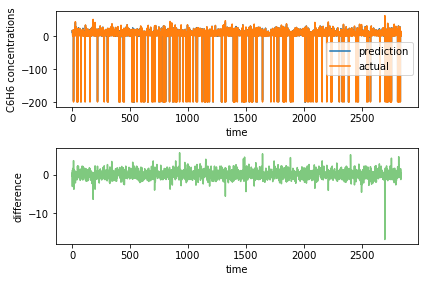

In [6]:
main()